<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Minutes-and-Statements" data-toc-modified-id="Minutes-and-Statements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Minutes and Statements</a></span></li><li><span><a href="#Word-Mover’s-Distance" data-toc-modified-id="Word-Mover’s-Distance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Mover’s Distance</a></span></li></ul></div>

# Measuring the Distance

In [1]:
import re
from collections import Counter
from os import listdir

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
import swifter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
# nltk.download('punkt')

d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## Minutes and Statements

After each meeting, the FOMC releases to the public a statement regarding its policy decision. The minutes of each regularly scheduled meeting of the Committee provide a timely summary of significant policy issues addressed by meeting participants. The minutes go back to 1936, but we found that it is not very informative, and it was not public until 1967, so ignored.

> "From 1936 through May 1967, the FOMC maintained for its use extensive "minutes," which were detailed records of attendance, discussions, and decisions at its meetings. " -- the FOMC official website. 

> "The Minutes of Actions, first released in 1967, were designed to provide this information. They were made available to the public on the same schedule as the Record of Policy Actions." -- the FOMC official website. 

After 1967, the minutes began public but varied from the recent minutes much. The current format of meeting minutes starts from 1993.

> "From their emergence in their present form in February 1993 until December 2004, the minutes were published approximately three days after the Committee's subsequent meeting. In December 2004, the Committee decided to expedite the release of its minutes. Since then, the minutes have been made available to the public three weeks after the date of the policy decision, thus reducing the lag in their release by an average of about three weeks." -- the FOMC official website. 

One year later, in February 1994, the FOMC first announced the outcome of a meeting, so the period of our dataset ranges from 1994-present.

> "After making several further post-meeting statements in 1994, the Committee formally announced in February 1995 that all changes in the stance of monetary policy would be immediately communicated to the public. In January 2000, the Committee announced that it would issue a statement following each regularly scheduled meeting, regardless of whether there had been a change in monetary policy." -- the FOMC official website. 

However, during hand-collecting the data from the FOMC's official website. We notice there is some inconsistency between minutes and statements. For example, on March 30, 1999, minutes were available, yet statements were not. After omitting these kind of imbalanced samples, we got 192 pairs of observations in total.
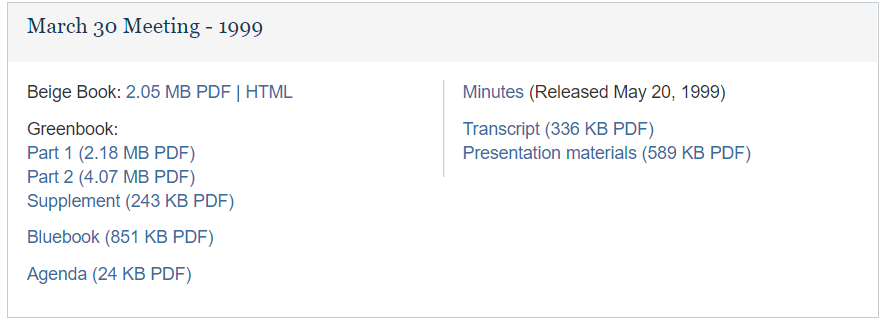

Furthermore, because present minutes comprise about ten parts, we only select the parts possibly containing "sentiment" narrative or discussion rather than objectively generated. Thus, we skip the first two and last three elements. Also, we ignore the citation of the statement included in the "Committee Policy Action" part.

- <font color=gray> Action to Adopt Changes to the Committee's Rules Regarding Availability of Information 
- <font color=gray> Developments in Financial Markets and Open Market Operations
- Staff Review of the Economic Situation
- Staff Review of the Financial Situation
- Staff Economic Outlook
- Participants' Views on Current Conditions and the Economic Outlook
- Committee Policy Action
- <font color=gray> Voting for this action
- <font color=gray> Voting against this action
- <font color=gray> Notation Vote

In [2]:
dates_statements, dates_minutes = [], []
with open('data\\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_statements.append(pd.to_datetime(line))
with open('data\\calendars_minutes.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_minutes.append(pd.to_datetime(line))
dates_minutes = pd.DataFrame(dates_minutes)
dates_statements = pd.DataFrame(dates_statements)
dates_minutes, dates_statements

(             0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-07-06
 4   1994-08-16
 ..         ...
 217 2021-03-17
 218 2021-04-28
 219 2021-06-16
 220 2021-07-28
 221 2021-09-22
 
 [222 rows x 1 columns],
              0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-08-16
 4   1994-11-15
 ..         ...
 187 2021-03-17
 188 2021-04-28
 189 2021-06-16
 190 2021-07-28
 191 2021-09-22
 
 [192 rows x 1 columns])

In [3]:
minutes = []
with open('data\\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/minutes/FOMC_' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            m = g.read().replace('\n', ' ').replace('\xad', '')
            minutes.append(m)
minutes = pd.DataFrame(minutes, columns=["minutes"])
minutes

,minutes
0,The information reviewed at this meeting indic...
1,The information reviewed at this meeting indic...
2,The information reviewed at this meeting sugge...
3,The information reviewed at this meeting sugge...
4,The information reviewed at this meeting sugge...
...,...
187,Staff Review of the Economic Situation The COV...
188,Staff Review of the Economic Situation The COV...
189,Staff Review of the Economic Situation The inf...
190,Staff Review of the Economic Situation The inf...


In [4]:
statements = []
with open('data\\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/statements/' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            s = g.read().replace('\n', '').replace('\\xad', '')
            statements.append(s)
statements = pd.DataFrame(statements, columns=["statements"])
statements

,statements
0,Chairman Alan Greenspan announced today that t...
1,Chairman Alan Greenspan announced today that t...
2,The Federal Reserve today announced two action...
3,The Federal Reserve announced today the follow...
4,The Federal Reserve Board today approved an in...
...,...
187,The Federal Reserve is committed to using its ...
188,The Federal Reserve is committed to using its ...
189,The Federal Reserve is committed to using its ...
190,The Federal Reserve is committed to using its ...


In [5]:
df_minutes = pd.concat([dates_statements, minutes], axis=1)
df_minutes.columns = ['date', 'minutes']
df_minutes.head()

,date,minutes
0,1994-02-04,The information reviewed at this meeting indic...
1,1994-03-22,The information reviewed at this meeting indic...
2,1994-05-17,The information reviewed at this meeting sugge...
3,1994-08-16,The information reviewed at this meeting sugge...
4,1994-11-15,The information reviewed at this meeting sugge...


In [6]:
df_statements = pd.concat([dates_statements, statements], axis=1)
df_statements.columns = ['date', 'statements']
df_statements.head()

,date,statements
0,1994-02-04,Chairman Alan Greenspan announced today that t...
1,1994-03-22,Chairman Alan Greenspan announced today that t...
2,1994-05-17,The Federal Reserve today announced two action...
3,1994-08-16,The Federal Reserve announced today the follow...
4,1994-11-15,The Federal Reserve Board today approved an in...


In [7]:
df_minutes["number of words"] = df_minutes["minutes"].swifter.apply(lambda x: sum(len(y.split()) for y in x.split('.')))
df_minutes["number of sentences"] = df_minutes["minutes"].swifter.apply(lambda x: len(x.split('.')))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [8]:
df_statements["number of words"] = df_statements["statements"].swifter.apply(
    lambda x: sum(len(y.split()) for y in x.split('.')))
df_statements["number of sentences"] = df_statements["statements"].swifter.apply(lambda x: len(x.split('.')))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

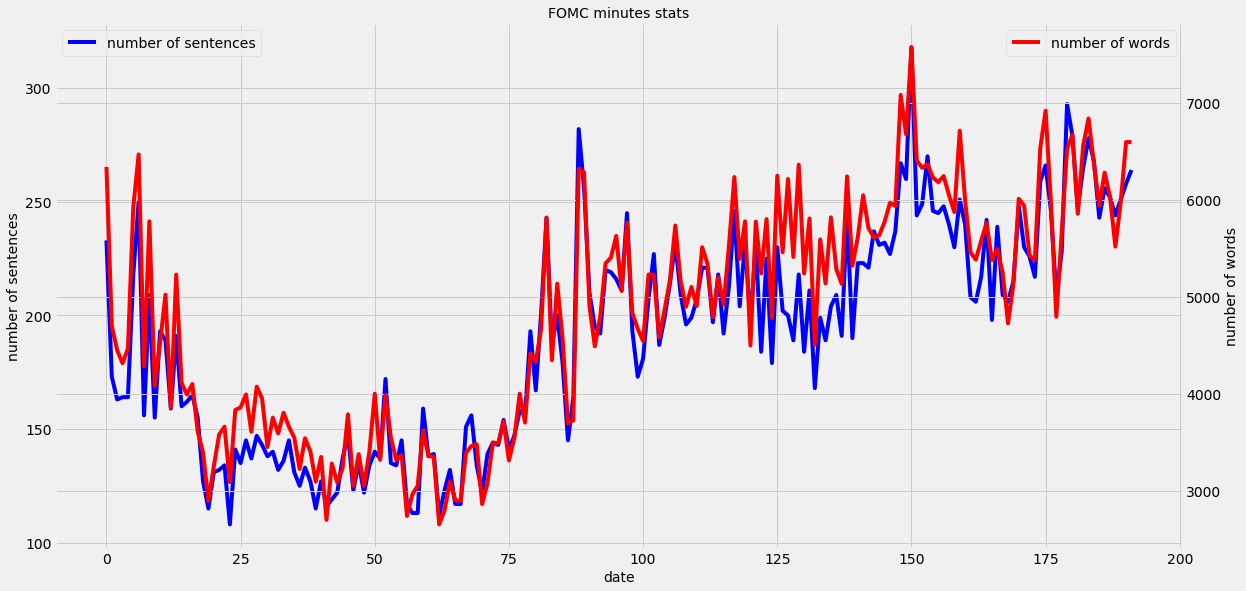

In [9]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df_minutes.index, df_minutes["number of sentences"], 'b', label='number of sentences')
ax2.plot(df_minutes.index, df_minutes["number of words"], 'r', label='number of words')
plt.title('FOMC minutes stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

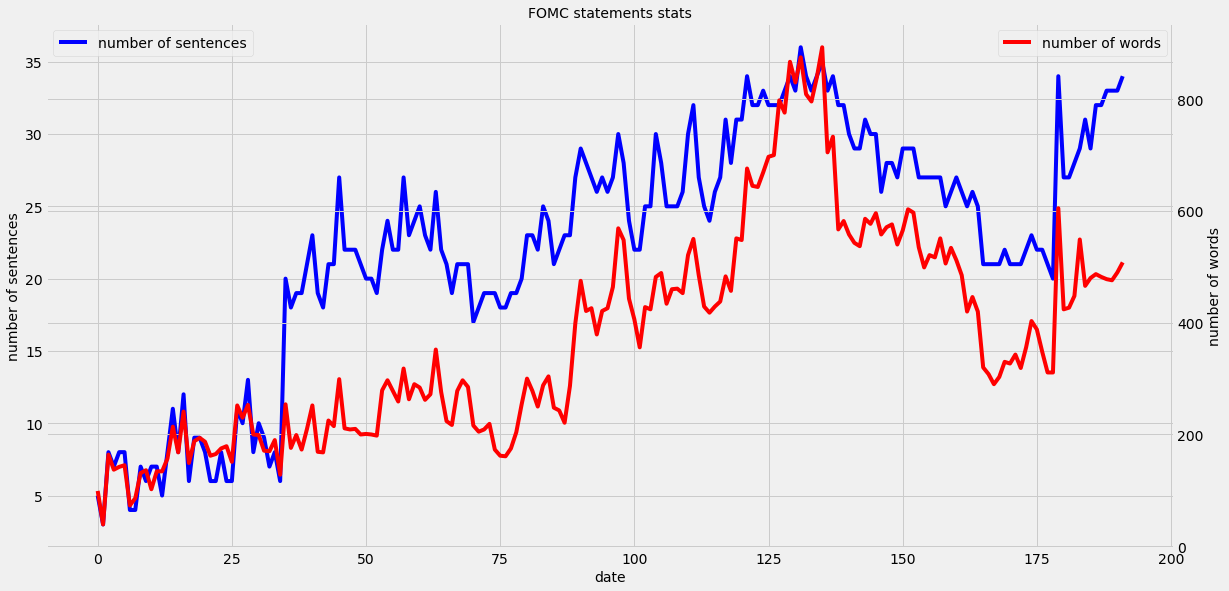

In [10]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_statements.index, df_statements["number of sentences"], 'b', label='number of sentences')
ax2 = ax.twinx()
ax2.plot(df_statements.index, df_statements["number of words"], 'r', label='number of words')
plt.title('FOMC statements stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

As we can see, the Fed has become very wordy over time, especially after the subprime crisis in 2008 and the COVID-19 shock in 2020. We also notice the length of minutes and statements were not growing at the same time. Then we use an industrial-strength natural language package `spacy` to compare the narrative between them.

In [11]:
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words
all_stopwords |= {'the', 'is', 'th', 's', 'm', 'would', 'The'}

d:\software\python\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [12]:
def my_tokenizer(doc):
    from nltk.tokenize import word_tokenize
    text = word_tokenize(doc)
    tokens_without_sw = [word for word in text if not word in all_stopwords]

    return tokens_without_sw

In [13]:
def preprocess_tokens(tokens):
    '''
    Remove any extra lines, non-letter characters, and blank quotes
    '''
    remove_new_lines = [re.sub('\s+', '', token) for token in tokens]
    #Remove non letter characters
    non_letters = [re.sub('[^a-zA-Z]', '', remove_new_line) for remove_new_line in remove_new_lines]
    #Remove distracting single quotes
    remove_quotes = [re.sub("\'", '', non_letter) for non_letter in non_letters]
    #Removes empty strings from a list of strings
    final = list(filter(None, remove_quotes))

    return final

In [14]:
def get_words(full_text):
    raw = [word.lower() for word in full_text.split()]

    values = ','.join(map(str, raw))  #converts bytes object to string
    tokenizer = my_tokenizer(values)

    words = preprocess_tokens(tokenizer)
    # remove stopwords
    stops = nltk.corpus.stopwords.words('english')
    new_stopwords = ['chairman', 'would', 'mr']
    stops.extend(new_stopwords)
    words = [word for word in words if word not in stops]
    counter = Counter()
    counter.update(words)
    most_common = counter.most_common(25)

    return words, most_common

In [15]:
df_minutes["all_words_minutes"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[0])
df_minutes["top_tokens"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[1])

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [16]:
df_statements["all_words_statements"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[0])
df_statements["top_tokens"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[1])

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [17]:
#Count the total word frequency of statements
word_df_statements = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_statements)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_statements['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_statements = pd.DataFrame(word_count)
    word_df_statements = word_df_statements.append(word_df1_statements, ignore_index=True)

total_words_statements = word_df_statements.groupby(['Words']).sum()
sorted_top_words_statements = total_words_statements.sort_values(by='Count', ascending=False)
sorted_top_words_1 = sorted_top_words_statements[:25]

In [18]:
#Count the total word frequency of minutes
word_df_minutes = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_minutes)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_minutes['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_minutes = pd.DataFrame(word_count)
    word_df_minutes = word_df_minutes.append(word_df1_minutes, ignore_index=True)

total_words_minutes = word_df_minutes.groupby(['Words']).sum()
sorted_top_words_minutes = total_words_minutes.sort_values(by='Count', ascending=False)
sorted_top_words_2 = sorted_top_words_minutes[:25]

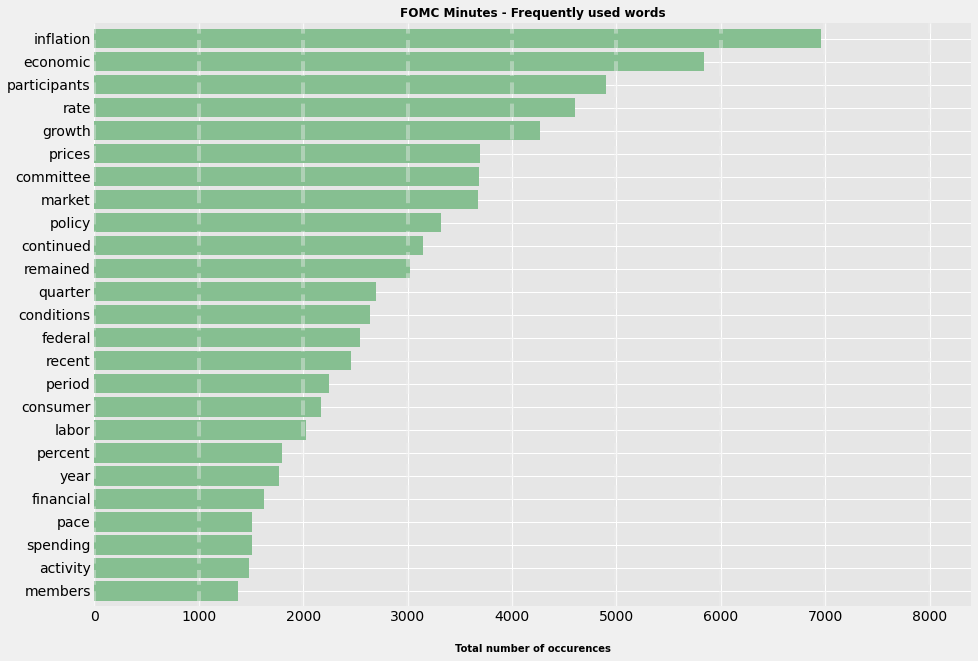

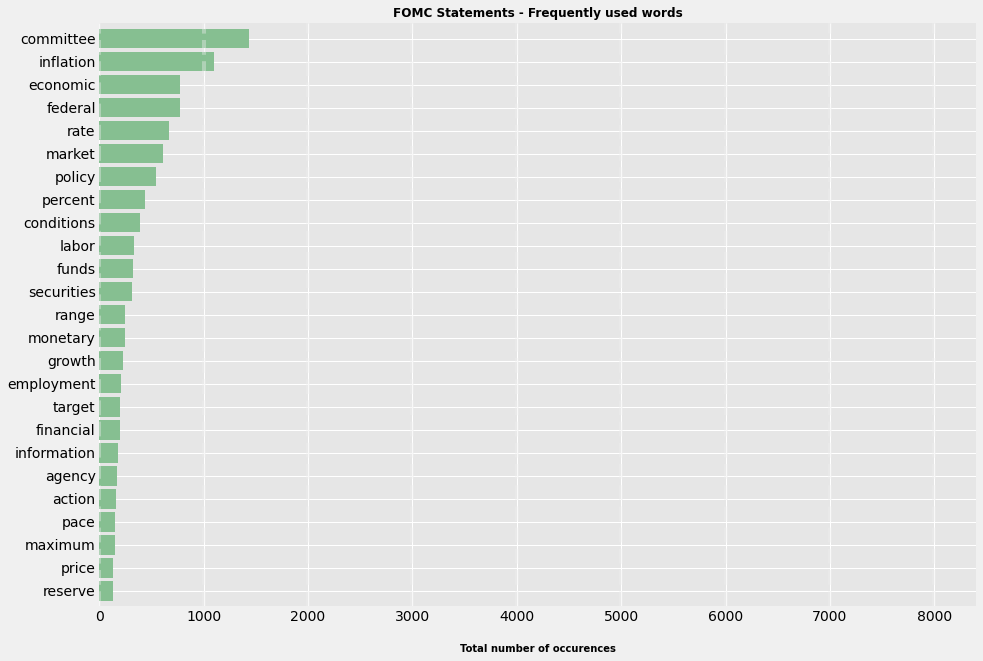

In [19]:
sorted_top_words_1 = sorted_top_words_1.sort_values(by="Count")
sorted_top_words_2 = sorted_top_words_2.sort_values(by="Count")

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

ax1 = sorted_top_words_2.plot(kind='barh', figsize=(14, 10), color='#86bf91', width=0.85)

ax1.get_legend().remove()
plt.title("FOMC Minutes - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
vals = ax1.get_xticks()
for tick in vals:
    ax1.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels
ax1.yaxis.label.set_visible(False)
ax1.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

ax2 = sorted_top_words_1.plot(kind='barh', figsize=(14, 10), color='#86bf91', width=0.85)

ax2.get_legend().remove()
plt.title("FOMC Statements - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
# vals = ax2.get_xticks()
for tick in vals:
    ax2.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels
ax2.yaxis.label.set_visible(False)
ax2.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

ax1.get_shared_x_axes().join(ax1, ax2)

We find both minutes and statements highlight inflation because the FOMC is in charge of two important goals. The first is to keep inflation at a target rate (2%). The second is to maximize the employment rate while the attention to the labor market of the two documents slightly differs. We will measure the distance between minutes and statements in the following section.

## Word Mover’s Distance

We use method `wmdistance` (Word Mover’s Distance) rather than traditional cosine similarity to measure the gap between minutes and statements since we consider the name cosine similarity may be bewildering. As we all know, two identical documents have a cosine similarity of 1, two documents have no common words a cosine similarity of 0. The two vectors are the count of each word in the two documents. So, cosine similarity is focusing on the existence of the words in the two dcocuments, that is the problem.

For example, here are two sentences. The first one is "Biden speaks to the media in Illinois". The second is "The president greets the press in Chicago". Usually these two sentences have the same meaning while we will see a zero consine similarity because there are no overlapping words after removing the stopwords.

Word Mover’s Distance (WMD) uses the word embeddings of the words in two texts to measure the minimum distance that the words in one text need to travel in semantic space to reach the words in the other text. Some word embeddings can be used like `Word2vec` and `GLove`. The WMD is measured by measuring the minimum Earth mover’s distance between each word in the two documents in word2vec space. if the distance is small then words in the two documents are close to each other.

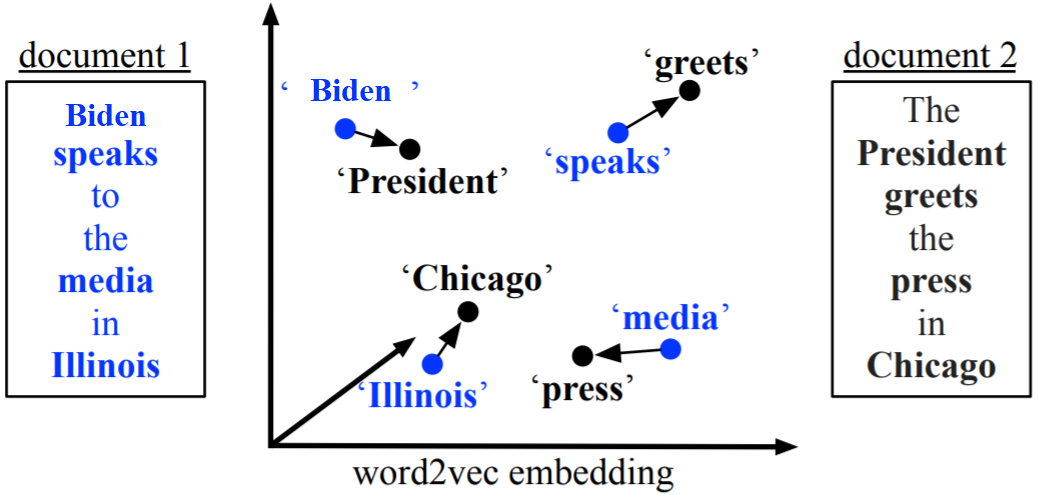

A text document is represented as a vector d, in which each element denotes a word’s normalized frequency in the document, i.e.
$$\begin{aligned}
    \mathbf{d} &=\left[d_{1,} d_{2}, \ldots, d_{n}\right]^{T}, \text { where } \\
    d_{i} &=\frac{c_{i}}{\sum_{j}^{n} c_{j}}, \\
    c_{i} &=\{\text {word }i \text{ appears citimes in a given document}\}
\end{aligned}$$

The Euclidean distance in embedding space of two given words, $\mathbf{x}_i$ and $\mathbf{x}_j$, is defined as follows:
\begin{equation}
    c(i,j) = ||\mathbf{x}_i - \mathbf{x}_j||^2
\end{equation}


In WMD, $\mathbf{x}_i$ and $\mathbf{x}_j$ are from different documents, and $c(i, j)$ is the “travel cost” from word $\mathbf{x}_i$ to $\mathbf{x}_j$.
Suppose there are a source document A and a target document B. A flow matrix $T$ is defined. Each element in the flow matrix, $T _{ij}$, denotes how many times of word $i$ (in document A) transforms into word $j$ (in document B), then normalize the value by the total count of words in the vocabulary. That is to say,
$$\sum_i T_{ij} = d_i\\
\sum_j T_{ij} = d_j$$

Therefore, the semantic distance definition is as follows:
$$
\text { distance }=\min _{\mathbf{T} \geqslant 0} \sum_{i, j=1}^{n} T_{i, j} c(i, j)
$$
By tuning values in $T$, the semantic distance between two documents can be obtained. The distance also is the minimum cumulative cost required to move all words from one document to the other.

In [20]:
docLabels_1 = [f for f in listdir("data/statements") if f.endswith('.txt')]
docLabels_2 = [f for f in listdir("data/minutes") if f.endswith('.txt') and f.strip('FOMC_') in docLabels_1]

In [21]:
data_1 = [
    TaggedDocument(get_words(open('data/statements/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i])
    for i, doc in enumerate(docLabels_1)]
data_2 = [
    TaggedDocument(get_words(open('data/minutes/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i + 192])
    for i, doc in enumerate(docLabels_2)]

In [22]:
data = data_1 + data_2

In [23]:
model = Doc2Vec(data, vector_size=50, window=1, min_count=1, workers=12)
fname = get_tmpfile("doc2vec_model")
model.save(fname)

In [24]:
model = Doc2Vec.load(fname)
Distance = []
with open('data\calendars_statements.txt', 'r') as f:
    i = 1
    for l in f.readlines():
        line = l.replace('\n', '')
        #         print('Distance between statements and minutes for the FOMC on date:',pd.to_datetime(line).strftime("%Y-%m-%d"))
        #         print(model.wv.distance(i, i + 192))
        Distance.append(model.wv.wmdistance(
            open('data/minutes/FOMC_' + line + r'.txt', 'r', encoding='utf8', errors='ignore').read().replace(
                '\n', ' ').replace('\xad', ''),
            open('data/statements/' + line + r'.txt', 'r', encoding='utf8', errors='ignore').read().replace(
                '\n', ' ').replace('\xad', '')))
        i += 1
Distance = pd.Series(Distance)

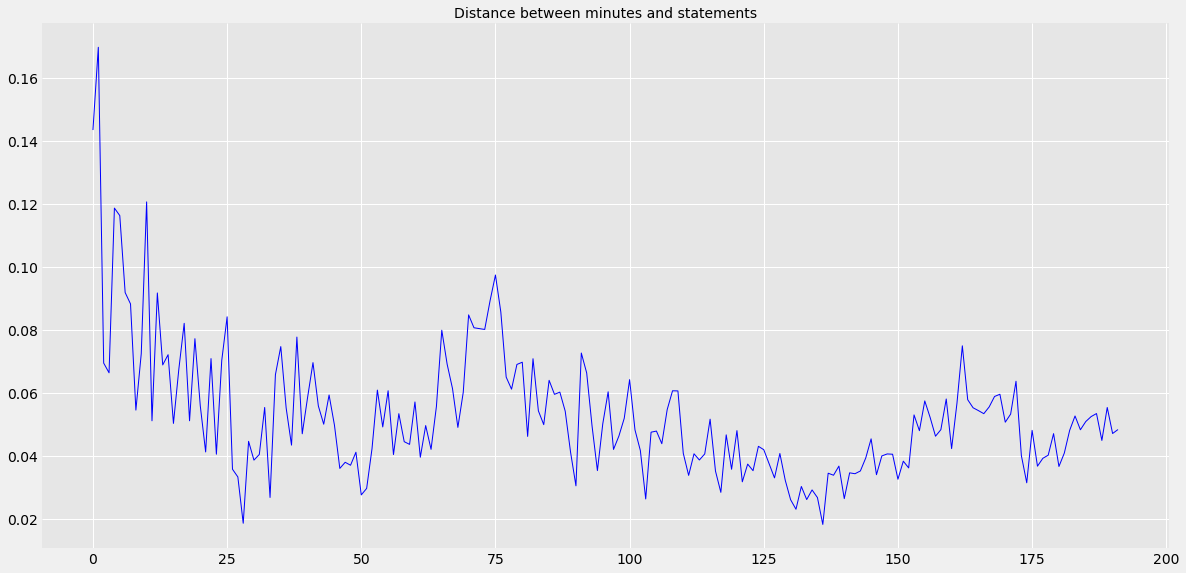

In [25]:
fig, ax = plt.subplots()
ax.plot(df_minutes.index, Distance, c='blue', linewidth=1.0)
plt.title('Distance between minutes and statements', size='medium')
plt.show()

In [26]:
Distance.describe()

count    192.000000
mean       0.052750
std        0.020774
min        0.018284
25%        0.039935
50%        0.049171
75%        0.060469
max        0.169788
dtype: float64

<AxesSubplot:>

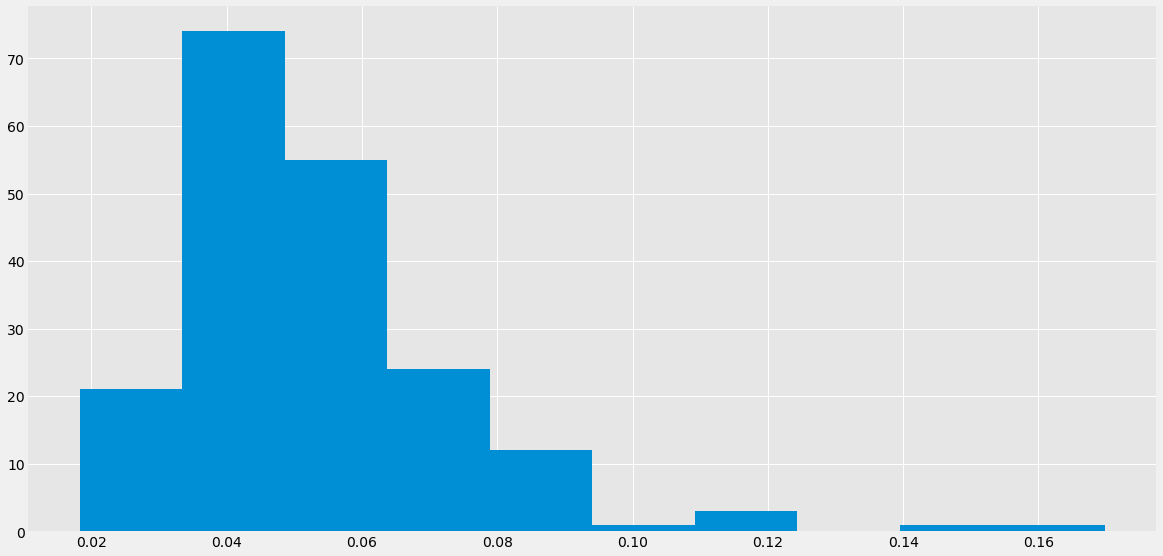

In [27]:
Distance.hist()

In [28]:
data_1_df = pd.DataFrame(data_1)
data_1_df['words'] = data_1_df['words'].apply(lambda x: " ".join(x))
data_1_df.drop(columns=['tags'], inplace=True)
data_1_df = pd.concat([data_1_df, dates_statements], axis=1)
data_1_df.columns = ["statements",'date']
data_1_df.to_feather('data_1.feather')

In [29]:
data_2_df = pd.DataFrame(data_2)
data_2_df['words'] = data_2_df['words'].apply(lambda x: " ".join(x))
data_2_df.drop(columns=['tags'], inplace=True)
data_2_df = pd.concat([data_2_df, dates_statements], axis=1)
data_2_df.columns = ["minutes",' date']
data_2_df.to_feather('data_2.feather')